## Imports and Constants

In [1]:
suppressPackageStartupMessages(suppressWarnings(library(ggplot2))) # plotting
suppressPackageStartupMessages(suppressWarnings(library(dplyr))) # data manipulation
suppressPackageStartupMessages(suppressWarnings(library(patchwork))) # figure composition
suppressPackageStartupMessages(suppressWarnings(library(cowplot))) # figure composition
suppressPackageStartupMessages(suppressWarnings(library(RcppTOML))) # parsing config file
suppressPackageStartupMessages(suppressWarnings(library(lattice))) # heatmap
suppressPackageStartupMessages(suppressWarnings(library(RColorBrewer))) # heatmap
suppressPackageStartupMessages(suppressWarnings(library(ComplexHeatmap))) # heatmap
suppressPackageStartupMessages(suppressWarnings(library(ggplotify))) # grob
suppressPackageStartupMessages(suppressWarnings(library(viridis))) # color
suppressPackageStartupMessages(suppressWarnings(library(platetools))) # make plate plot
suppressPackageStartupMessages(suppressWarnings(library(circlize))) 
suppressPackageStartupMessages(suppressWarnings(library(reshape2))) # data manipulation
suppressPackageStartupMessages(suppressWarnings(library(stringr))) # string manipulation
suppressPackageStartupMessages(suppressWarnings(library(purrr))) # data manipulation
suppressPackageStartupMessages(suppressWarnings(library(VennDiagram))) # venn diagram
suppressPackageStartupMessages(suppressWarnings(library(tidyverse))) # data manipulation
suppressPackageStartupMessages(suppressWarnings(library(ggvenn))) # venn diagram
suppressPackageStartupMessages(suppressWarnings(library(grid))) # grid
suppressPackageStartupMessages(suppressWarnings(library(Polychrome)))

source("../../utils/figure_themes.r")


In [2]:
cell_type <- "PBMC"


In [3]:
montage_image_path = file.path("../figures/PBMC_montage.png")
montage_image = png::readPNG(montage_image_path)


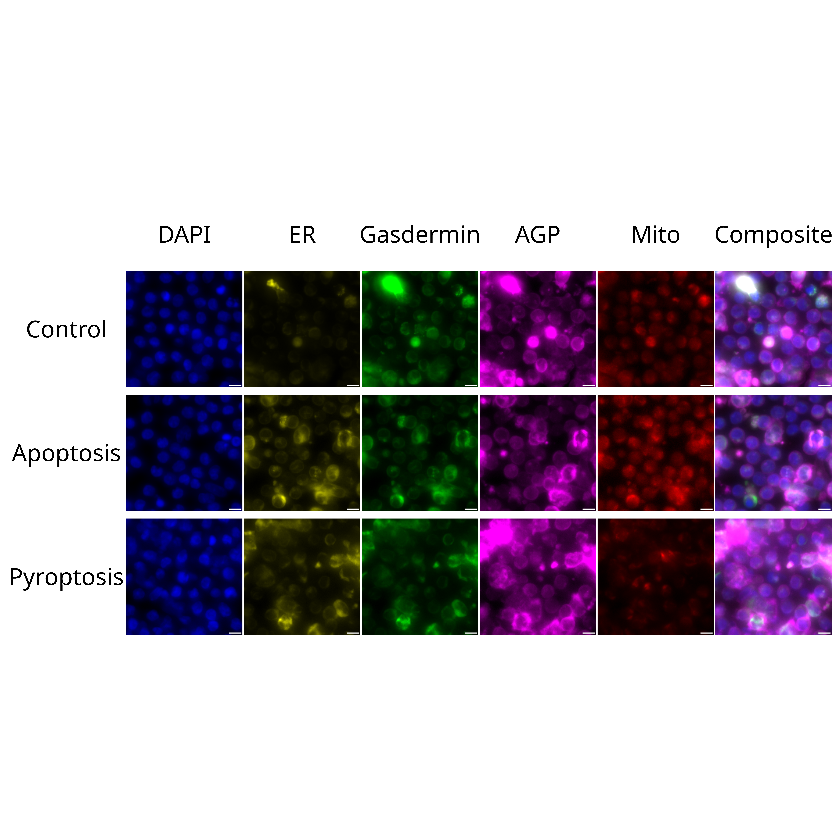

In [4]:
# plot the montage image to a ggplot object
montage <- (
    ggplot()
    + annotation_custom(
        rasterGrob(montage_image, interpolate = TRUE),
        xmin=-Inf, xmax=Inf, ymin=-Inf, ymax=Inf
    )
    + theme_void()
)
montage


In [5]:
# set path to anova results
anova_results_path = file.path(paste0(
    "../../../1.Exploratory_Data_Analysis/results/",cell_type,"_combined.parquet"
))
# read in path
anova_results = arrow::read_parquet(anova_results_path)


In [6]:
# create a column that adds group1 and group2 together
anova_results$group = paste0(anova_results$group1,"_",anova_results$group2)


In [7]:
# filter out rows that have p-adj_abs > 0.05
anova_results = anova_results %>% filter(`p-adj_abs` < 0.05)


In [8]:
# change the group names to replace healhty with    control
anova_results$group = str_replace_all(anova_results$group,"healthy","control")


In [9]:
# create the three df sets for a venn diagram
a_h <- anova_results %>% filter(group == "apoptosis_control")
a_p <- anova_results %>% filter(group == "apoptosis_pyroptosis")
h_p <- anova_results %>% filter(group == "control_pyroptosis")
a_h <- a_h %>% select(features)
a_p <- a_p %>% select(features)
h_p <- h_p %>% select(features)

# create a list of the three df sets
a_h_list <- a_h %>% pull(features)
a_p_list <- a_p %>% pull(features)
h_p_list <- h_p %>% pull(features)

x=list(a_h_list,a_p_list,h_p_list)


In [10]:
# set plot size 
width <- 10
height <- 10
options(repr.plot.width=width, repr.plot.height=height)
myCol <- brewer.pal(3, "Dark2")
venn_diagram_plot <- venn.diagram(
    x=x,
    show=TRUE,
    category.names = c("Apoptosis \nvs \nControl","Apoptosis \nvs \nPyroptosis","Control \nvs \nPyroptosis"),
    filename = paste0("../figures/",cell_type,"_venn_diagram.png"),
    # Output features
    imagetype="png" , 
    resolution = 600,
    compression = "lzw",
    
    # Circles
    lwd = 2,
    lty = 'blank',
    fill = myCol,
    
    # Numbers
    cex = 1,
    fontface = "bold",
    fontfamily = "sans",
    
    # Set names
    cat.cex = 0.8,
    cat.fontface = "bold",
    cat.default.pos = "outer",
    cat.pos = c(-26, 23, 0),
    cat.dist = c(-0.03, -0.03, -0.39),
    cat.fontfamily = "sans",
    rotation = 1

)


In [11]:
# Set the directory path
directory <- "../figures"
# List all files in the directory
files <- list.files(directory, full.names = TRUE)
# Filter files that end with ".log"
log_files <- files[grep(".log$", files)]
# Remove the log files
file.remove(log_files)


[1] TRUE

[1] "gg"     "ggplot"

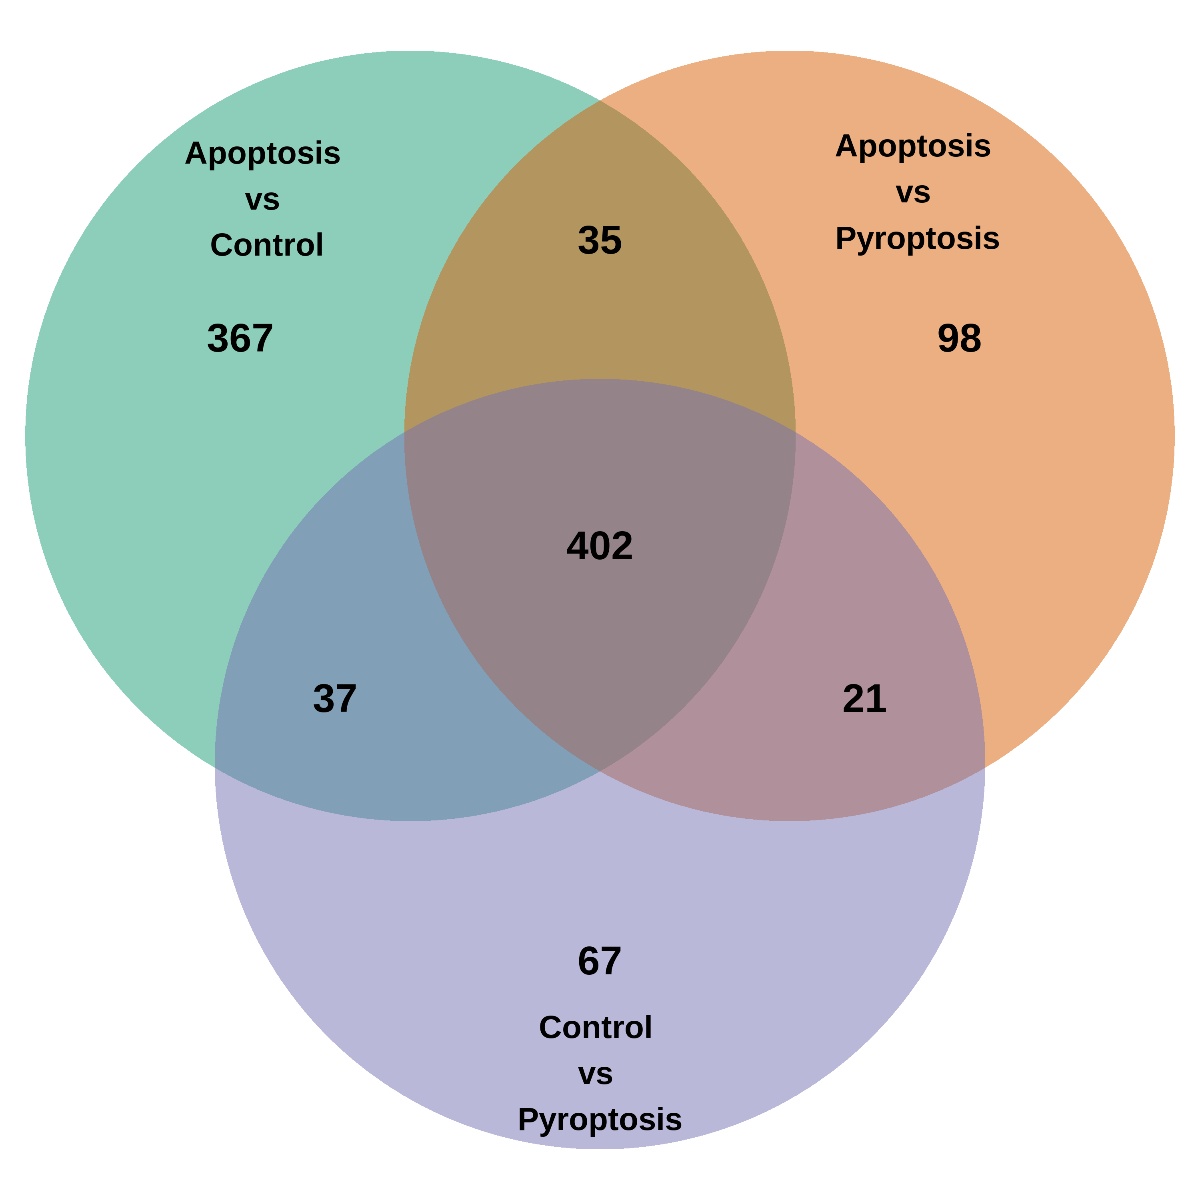

In [12]:
# read in the venn diagram from PNG
venn_diagram_image_path = file.path(paste0("../figures/",cell_type,"_venn_diagram.png"))
venn_diagram_image = png::readPNG(venn_diagram_image_path)
# plot the montage image to a ggplot object
venn_diagram_image <- (
    ggplot()
    + annotation_custom(
        rasterGrob(venn_diagram_image, interpolate = TRUE),
        xmin=-Inf, xmax=Inf, ymin=-Inf, ymax=Inf
    )
    + theme_void()
)
# get the type of the object
class(venn_diagram_image)
venn_diagram_image


### Find the unique features for each class 
### Find the overlapping features between classes

In [13]:
# add sets together
a_h__a_p <- union(a_h_list, a_p_list)
a_h__h_p <- union(a_h_list ,h_p_list)
a_p__h_p <- union(a_p_list ,h_p_list)

# get the unique features for each set
# Apoptosis_vs_Control
# should be 117
a_h_unique <- setdiff(a_h_list, a_p__h_p)

# Apoptosis_vs_Pyroptosis
# should be 17
a_p_unique <- setdiff(a_p_list, a_h__h_p)

# Control_vs_Pyroptosis
# should be 305
h_p_unique <- setdiff(h_p_list, a_h__a_p)

# get the common features for each set
# Apoptosis_vs_Control and Apoptosis_vs_Pyroptosis
# should be 5
a_h__a_p_common <- intersect(a_h_list, a_p_list)
a_h__a_p_common <- setdiff(a_h__a_p_common, h_p_list)

# Apoptosis_vs_Control and Control_vs_Pyroptosis
# should be 27
a_h__h_p_common <- intersect(a_h_list, h_p_list)
a_h__h_p_common <- setdiff(a_h__h_p_common, a_p_list)

# Apoptosis_vs_Pyroptosis and Control_vs_Pyroptosis
# should be 16
a_p__h_p_common <- intersect(a_p_list, h_p_list)
a_p__h_p_common <- setdiff(a_p__h_p_common, a_h_list)

# all three set intersection
# should be 406
a_h__a_p__h_p_common <- intersect(a_h_list, a_p_list)
a_h__a_p__h_p_common <- intersect(a_h__a_p__h_p_common, h_p_list)


#### Get df ready for plotting

In [14]:
anova_results_channels <- anova_results %>%
    # dplyr::arrange(desc(abs(group))) %>%
    tidyr::separate(
        features,
        into = c(
            "compartment",
            "feature_group",
            "measurement",
            "channel", 
            "parameter1", 
            "parameter2"
        ),
        sep = "_",
        remove = FALSE
    ) %>%
    dplyr::mutate(channel_cleaned = channel)
    # dplyr::arrange(desc(abs(group)))

# Clean channel for visualization
anova_results_channels$channel_learned <- dplyr::recode(anova_results_channels$channel_cleaned,
        "CorrDNA" = "nuclei",
        "CorrMito" = "Mito",
        "CorrER" = "ER",
        "CorrGasdermin" = "gasdermin",
        "CorrPM" = "PM",
        .default = "other",
        .missing="other"
    )
# rename the values in channel learned
anova_results_channels$channel_learned <- dplyr::recode(anova_results_channels$channel_learned,
        "nuclei" = "Nuclei",
        "Mito" = "Mito",
        "ER" = "ER",
        "gasdermin" = "GasderminD",
        "PM" = "AGP",
        .default = "other",
        .missing="Other"
    )
anova_results_channels$channel_learned <- factor(anova_results_channels$channel_learned, levels = c("Nuclei","Mito","ER","GasderminD","AGP","Other"))


Warning message:
“Expected 6 pieces. Additional pieces discarded in 218 rows [4, 5, 6, 7, 8, 9,
20, 24, 44, 62, 63, 88, 92, 106, 130, 134, 135, 136, 159, 186, ...].”
Warning message:
“Expected 6 pieces. Missing pieces filled with `NA` in 436 rows [13, 14, 15, 16,
28, 35, 38, 39, 40, 41, 49, 50, 51, 52, 64, 82, 83, 84, 93, 102, ...].”


In [15]:
# select specfic colors from the color palette
DAPI <- brewer.pal(12,"Paired")[2]
ER <- brewer.pal(12,"Paired")[8]
Gasdermin <- brewer.pal(12,"Paired")[4]
PM <- brewer.pal(12,"Paired")[10]
Mito <- brewer.pal(12,"Paired")[6]
Other <- brewer.pal(8, "Accent")[8]


In [16]:
unique(anova_results_channels$channel_learned)

[1] Nuclei     AGP        Mito       <NA>       ER         GasderminD
Levels: Nuclei Mito ER GasderminD AGP Other

In [17]:
# factorize the channel_cleaned column
anova_results_channels$channel_learned <- factor(anova_results_channels$channel_learned, levels = c("Nuclei","ER","GasderminD","AGP","Mito","Other"))

In [18]:
# set plot size
width <- 10
height <- 10
options(repr.plot.width=width, repr.plot.height=height)
unique_feature_plot_function <- function(df, list_of_unique_features){
    filtered_df <- df %>% filter(features %in% list_of_unique_features)
    # drop duplicate features
    filtered_df <- filtered_df[!duplicated(filtered_df$features),]
    # count the data
    filtered_df_counts <- count(filtered_df, channel_learned)
    # make <NA> vlues in channel_learned Other
    filtered_df_counts$channel_learned <- replace_na(filtered_df_counts$channel_learned, "Other")
    plot <- (
        ggplot(filtered_df_counts, aes(x=channel_learned, y=n, fill=channel_learned))
        + geom_bar(stat = "identity")
        + theme_bw()
        # change colours of bars manually
        + scale_fill_manual(values = c("Nuclei" = DAPI, "Mito" = Mito, "ER" = ER, "GasderminD" = Gasdermin, "AGP" = PM, "Other" = Other))
        + labs(
            x = "Channel",
            y = "Feature count",
        )
        # legend title change
        
        + guides(fill = guide_legend(title = "Channel"))
        + figure_theme
        # drop the x axis ticks
        + theme(
            axis.text.x = element_blank(),
            axis.ticks.x = element_blank()
        )
        # add the counts to the top of the bars
        + geom_text(
            aes(label=n),
            vjust=-0.5,
            size=6
        )
        + ylim(0, 150)
        
    )
    plot <- plot + scale_x_discrete(drop = FALSE)
    return(plot)
}

a_h_unique_plot <- unique_feature_plot_function(anova_results_channels, a_h_unique)
a_p_unique_plot <- unique_feature_plot_function(anova_results_channels, a_p_unique)
h_p_unique_plot <- unique_feature_plot_function(anova_results_channels, h_p_unique)
a_h__a_p_common_plot <- unique_feature_plot_function(anova_results_channels, a_h__a_p_common)
a_h__h_p_common_plot <- unique_feature_plot_function(anova_results_channels, a_h__h_p_common)
a_p__h_p_common_plot <- unique_feature_plot_function(anova_results_channels, a_p__h_p_common)
a_h__a_p__h_p_common_plot <- unique_feature_plot_function(anova_results_channels, a_h__a_p__h_p_common)

# add titles to each plot
a_h_unique_plot <- a_h_unique_plot + labs(title = "Apoptosis vs Control")
a_p_unique_plot <- a_p_unique_plot + labs(title = "Apoptosis vs Pyroptosis")
h_p_unique_plot <- h_p_unique_plot + labs(title = "Control vs Pyroptosis")
a_h__a_p_common_plot <- a_h__a_p_common_plot + labs(title = "Common Features in Apoptosis vs Control and Apoptosis vs Pyroptosis")
a_h__h_p_common_plot <- a_h__h_p_common_plot + labs(title = "Common Features in Apoptosis vs Control and Control vs Pyroptosis")
a_p__h_p_common_plot <- a_p__h_p_common_plot + labs(title = "Common Features in Apoptosis vs Pyroptosis and Control vs Pyroptosis")
a_h__a_p__h_p_common_plot <- a_h__a_p__h_p_common_plot + labs(title = "Common Features in Apoptosis vs Control, Apoptosis vs Pyroptosis and Control vs Pyroptosis")


## UMAP of morphological features

In [19]:
cell_umap_path <- file.path(paste0(
    "../","../","../","1.Exploratory_Data_Analysis/results/",cell_type,"_umap_values_morphology_all_cells.parquet"

))

cell_umap <- arrow::read_parquet(cell_umap_path)
print(paste0("Number of cells: ",nrow(cell_umap)))

# subset the cells for trial of plots
# cell_umap <- cell_umap %>% sample_n(1000)

[1] "Number of cells: 8318724"


In [20]:
# Load data
data_path_cytokine_values <- file.path("../../../2.Nomic_nELISA_Analysis/Data/clean/Plate2/nELISA_plate_430420_PBMC_clean.parquet")
cytokine_values <- arrow::read_parquet(data_path_cytokine_values)
# read in the ground truth data
data_path_ground_truth <- file.path("../../../4.sc_Morphology_Neural_Network_MLP_Model/MLP_utils/ground_truth.toml")
ground_truth <- parseTOML(data_path_ground_truth)
# make a a list of the treatments that are in the ground truth data
apoptosis_ground_truth_list <- c(ground_truth$Apoptosis$apoptosis_groups_list)
pyroptosis_ground_truth_list <- c(ground_truth$Pyroptosis$pyroptosis_groups_list)
control_ground_truth_list <- c(ground_truth$Healthy$healthy_groups_list)

In [21]:
# replace Flagellin_0.100_ug_per_ml_DMSO_0.0_% with Flagellin_0.100_ug_per_ml_DMSO_0.025_%

cell_umap$oneb_Metadata_Treatment_Dose_Inhibitor_Dose <- ifelse(cell_umap$oneb_Metadata_Treatment_Dose_Inhibitor_Dose == "Flagellin_0.100_ug_per_ml_DMSO_0.000_%", "Flagellin_0.100_ug_per_ml_DMSO_0.025_%", cell_umap$oneb_Metadata_Treatment_Dose_Inhibitor_Dose)
cell_umap$oneb_Metadata_Treatment_Dose_Inhibitor_Dose <- ifelse(cell_umap$oneb_Metadata_Treatment_Dose_Inhibitor_Dose == "media_ctr_0.0_0_Media_0_0", "media_ctr_0.0_0_Media_ctr_0.0_0", cell_umap$oneb_Metadata_Treatment_Dose_Inhibitor_Dose)
cell_umap$oneb_Metadata_Treatment_Dose_Inhibitor_Dose <- ifelse(cell_umap$oneb_Metadata_Treatment_Dose_Inhibitor_Dose == "Flagellin_1.000_ug_per_ml_DMSO_0.000_%", "Flagellin_1.000_ug_per_ml_DMSO_0.0_%", cell_umap$oneb_Metadata_Treatment_Dose_Inhibitor_Dose)
cell_umap$oneb_Metadata_Treatment_Dose_Inhibitor_Dose <- ifelse(cell_umap$oneb_Metadata_Treatment_Dose_Inhibitor_Dose == "Flagellin_1.000_0_Disulfiram_1.000_uM", "Flagellin_1.000_ug_per_ml_Disulfiram_1.000_uM", cell_umap$oneb_Metadata_Treatment_Dose_Inhibitor_Dose)
cell_umap$oneb_Metadata_Treatment_Dose_Inhibitor_Dose <- ifelse(cell_umap$oneb_Metadata_Treatment_Dose_Inhibitor_Dose == "Flagellin_1.000_ug_per_ml_DMSO_0.000_%", "Flagellin_1.000_ug_per_ml_DMSO_0.0_%", cell_umap$oneb_Metadata_Treatment_Dose_Inhibitor_Dose)
cell_umap$oneb_Metadata_Treatment_Dose_Inhibitor_Dose <- ifelse(cell_umap$oneb_Metadata_Treatment_Dose_Inhibitor_Dose == "Flagellin_1.000_0_DMSO_0.025_%", "Flagellin_1.000_ug_per_ml_DMSO_0.0_%", cell_umap$oneb_Metadata_Treatment_Dose_Inhibitor_Dose)

# make a new column that is the treatment group based on the ground truth data
cell_umap$group <- ifelse(cell_umap$oneb_Metadata_Treatment_Dose_Inhibitor_Dose %in% apoptosis_ground_truth_list, "Apoptosis",
                                ifelse(cell_umap$oneb_Metadata_Treatment_Dose_Inhibitor_Dose %in% pyroptosis_ground_truth_list, "Pyroptosis",
                                       ifelse(cell_umap$oneb_Metadata_Treatment_Dose_Inhibitor_Dose %in% control_ground_truth_list, "Control", "NA")))
# make the group column a factor
cell_umap$group <- factor(cell_umap$group, levels = c("Control","Apoptosis", "Pyroptosis"))

In [22]:
# mutate the names of each treatment

cell_umap <- cell_umap %>%
    mutate(oneb_Metadata_Treatment_Dose_Inhibitor_Dose = case_when(
        oneb_Metadata_Treatment_Dose_Inhibitor_Dose == 'DMSO_0.100_%_DMSO_0.025_%' ~ "DMSO 0.1% - DMSO 0.025%",
        oneb_Metadata_Treatment_Dose_Inhibitor_Dose == 'DMSO_0.100_%_DMSO_1.000_%' ~ "DMSO 0.1% - DMSO 1.0%",
        oneb_Metadata_Treatment_Dose_Inhibitor_Dose == 'DMSO_0.100_%_Z-VAD-FMK_100.000_uM' ~ "DMSO 0.1% - Z-VAD-FMK 100.0 uM",
        oneb_Metadata_Treatment_Dose_Inhibitor_Dose == 'DMSO_0.100_%_Z-VAD-FMK_30.000_uM' ~ "DMSO 0.1% - Z-VAD-FMK 30.0 uM",
        oneb_Metadata_Treatment_Dose_Inhibitor_Dose == 'Disulfiram_0.100_uM_DMSO_0.025_%' ~ "Disulfiram 0.1 uM - DMSO 0.025%",
        oneb_Metadata_Treatment_Dose_Inhibitor_Dose == 'Disulfiram_1.000_uM_DMSO_0.025_%' ~ "Disulfiram 1.0 uM - DMSO 0.025%",
        oneb_Metadata_Treatment_Dose_Inhibitor_Dose == 'Disulfiram_2.500_uM_DMSO_0.025_%' ~ "Disulfiram 2.5 uM - DMSO 0.025%",
        oneb_Metadata_Treatment_Dose_Inhibitor_Dose == 'Flagellin_0.100_ug_per_ml_DMSO_0.025_%' ~ "Flagellin 0.1 ug/ml - DMSO 0.025%",
        oneb_Metadata_Treatment_Dose_Inhibitor_Dose == 'Flagellin_1.000_ug_per_ml_DMSO_0.025_%' ~ "Flagellin 1.0 ug/ml - DMSO 0.025%",
        oneb_Metadata_Treatment_Dose_Inhibitor_Dose == 'Flagellin_1.000_ug_per_ml_Disulfiram_1.000_uM' ~ "Flagellin 1.0 ug/ml - Disulfiram 1.0 uM",
        oneb_Metadata_Treatment_Dose_Inhibitor_Dose == 'H2O2_100.000_nM_DMSO_0.025_%' ~ "H2O2 100.0 nM - DMSO 0.025%",
        oneb_Metadata_Treatment_Dose_Inhibitor_Dose == 'H2O2_100.000_uM_DMSO_0.025_%' ~ "H2O2 100.0 uM - DMSO 0.025%",
        oneb_Metadata_Treatment_Dose_Inhibitor_Dose == 'H2O2_100.000_uM_Disulfiram_1.000_uM' ~ "H2O2 100.0 uM - Disulfiram 1.0 uM",
        oneb_Metadata_Treatment_Dose_Inhibitor_Dose == 'H2O2_100.000_uM_Z-VAD-FMK_100.000_uM' ~ "H2O2 100.0 uM - Z-VAD-FMK 100.0 uM",
        oneb_Metadata_Treatment_Dose_Inhibitor_Dose == 'LPS_0.010_ug_per_ml_DMSO_0.025_%' ~ "LPS 0.01 ug/ml - DMSO 0.025%",
        oneb_Metadata_Treatment_Dose_Inhibitor_Dose == 'LPS_0.100_ug_per_ml_DMSO_0.025_%' ~ "LPS 0.1 ug/ml - DMSO 0.025%",
        oneb_Metadata_Treatment_Dose_Inhibitor_Dose == 'LPS_1.000_ug_per_ml_DMSO_0.025_%' ~ "LPS 1.0 ug/ml - DMSO 0.025%",
        oneb_Metadata_Treatment_Dose_Inhibitor_Dose == 'LPS_10.000_ug_per_ml_DMSO_0.025_%' ~ "LPS 10.0 ug/ml - DMSO 0.025%",
        oneb_Metadata_Treatment_Dose_Inhibitor_Dose == 'LPS_10.000_ug_per_ml_Disulfiram_0.100_uM' ~ "LPS 10.0 ug/ml - Disulfiram 0.1 uM",
        oneb_Metadata_Treatment_Dose_Inhibitor_Dose == 'LPS_10.000_ug_per_ml_Disulfiram_1.000_uM' ~ "LPS 10.0 ug/ml - Disulfiram 1.0 uM",
        oneb_Metadata_Treatment_Dose_Inhibitor_Dose == 'LPS_10.000_ug_per_ml_Disulfiram_2.500_uM' ~ "LPS 10.0 ug/ml - Disulfiram 2.5 uM",
        oneb_Metadata_Treatment_Dose_Inhibitor_Dose == 'LPS_10.000_ug_per_ml_Z-VAD-FMK_100.000_uM' ~ "LPS 10.0 ug/ml - Z-VAD-FMK 100.0 uM",
        oneb_Metadata_Treatment_Dose_Inhibitor_Dose == 'LPS_100.000_ug_per_ml_DMSO_0.025_%' ~ "LPS 100.0 ug/ml - DMSO 0.025%",
        oneb_Metadata_Treatment_Dose_Inhibitor_Dose == 'LPS_Nigericin_100.000_ug_per_ml_1.000_uM_DMSO_0.025_%' ~ "LPS 100.0 ug/ml + Nigericin 1.0 uM - DMSO 0.025%",
        oneb_Metadata_Treatment_Dose_Inhibitor_Dose == 'LPS_Nigericin_100.000_ug_per_ml_3.000_uM_DMSO_0.025_%' ~ "LPS 100.0 ug/ml + Nigericin 3.0 uM - DMSO 0.025%",
        oneb_Metadata_Treatment_Dose_Inhibitor_Dose == 'LPS_Nigericin_100.000_ug_per_ml_10.000_uM_DMSO_0.025_%' ~ "LPS 100.0 ug/ml + Nigericin 10.0 uM - DMSO 0.025%",
        oneb_Metadata_Treatment_Dose_Inhibitor_Dose == 'LPS_Nigericin_1.000_ug_per_ml_1.000_uM_DMSO_0.025_%' ~ "LPS 1.0 ug/ml + Nigericin 1.0 uM - DMSO 0.025%",
        oneb_Metadata_Treatment_Dose_Inhibitor_Dose == 'LPS_Nigericin_1.000_ug_per_ml_3.000_uM_DMSO_0.025_%' ~ "LPS 1.0 ug/ml + Nigericin 3.0 uM - DMSO 0.025%",
        oneb_Metadata_Treatment_Dose_Inhibitor_Dose == 'LPS_Nigericin_1.000_ug_per_ml_10.000_uM_DMSO_0.025_%' ~ "LPS 1.0 ug/ml + Nigericin 10.0 uM - DMSO 0.025%",
        oneb_Metadata_Treatment_Dose_Inhibitor_Dose == 'LPS_Nigericin_1.000_ug_per_ml_10.000_uM_Disulfiram_1.000_uM' ~ "LPS 1.0 ug/ml + Nigericin 10.0 uM - Disulfiram 1.0 uM",
        oneb_Metadata_Treatment_Dose_Inhibitor_Dose == 'LPS_Nigericin_1.000_ug_per_ml_10.000_uM_Z-VAD-FMK_100.000_uM' ~ "LPS 1.0 ug/ml + Nigericin 10.0 uM - Z-VAD-FMK 100.0 uM",
        oneb_Metadata_Treatment_Dose_Inhibitor_Dose == 'Media' ~ "Media",
        TRUE ~ oneb_Metadata_Treatment_Dose_Inhibitor_Dose
    ))

In [23]:
# create grouping of treatment and group
cell_umap$group_treatment <- paste(cell_umap$oneb_Metadata_Treatment_Dose_Inhibitor_Dose, cell_umap$group,  sep = ", ")
# make the group_treatment column a factor
cell_umap$group_treatment <- factor(
    cell_umap$group_treatment, 
    levels = c(
        levels = c(
            'DMSO 0.1% - DMSO 0.025%, Control',
            'DMSO 0.1% - DMSO 1.0%, Control',
            'DMSO 0.1% - Z-VAD-FMK 100.0 uM, Control',
            'DMSO 0.1% - Z-VAD-FMK 30.0 uM, Control',
            'Disulfiram 0.1 uM - DMSO 0.025%, Control',
            'Disulfiram 1.0 uM - DMSO 0.025%, Control',
            'Disulfiram 2.5 uM - DMSO 0.025%, Control',
            'Flagellin 0.1 ug/ml - DMSO 0.025%, Pyroptosis',
            'Flagellin 1.0 ug/ml - DMSO 0.025%, Pyroptosis',
            'Flagellin 1.0 ug/ml - Disulfiram 1.0 uM, Pyroptosis',
            'H2O2 100.0 nM - DMSO 0.025%, Control',
            'H2O2 100.0 uM - DMSO 0.025%, Control',
            'H2O2 100.0 uM - Disulfiram 1.0 uM, Control',
            'H2O2 100.0 uM - Z-VAD-FMK 100.0 uM, Control',
            'LPS 0.01 ug/ml - DMSO 0.025%, Pyroptosis',
            'LPS 0.1 ug/ml - DMSO 0.025%, Pyroptosis',
            'LPS 1.0 ug/ml - DMSO 0.025%, Pyroptosis',
            'LPS 1.0 ug/ml + Nigericin 1.0 uM - DMSO 0.025%, Pyroptosis',
            'LPS 1.0 ug/ml + Nigericin 10.0 uM - DMSO 0.025%, Pyroptosis',
            'LPS 1.0 ug/ml + Nigericin 10.0 uM - Disulfiram 1.0 uM, Pyroptosis',
            'LPS 1.0 ug/ml + Nigericin 10.0 uM - Z-VAD-FMK 100.0 uM, Control',
            'LPS 1.0 ug/ml + Nigericin 3.0 uM - DMSO 0.025%, Pyroptosis',
            'LPS 10.0 ug/ml - DMSO 0.025%, Pyroptosis',
            'LPS 10.0 ug/ml - Disulfiram 0.1 uM, Pyroptosis',
            'LPS 10.0 ug/ml - Disulfiram 1.0 uM, Pyroptosis',
            'LPS 10.0 ug/ml - Disulfiram 2.5 uM, Pyroptosis',
            'LPS 10.0 ug/ml - Z-VAD-FMK 100.0 uM, Control',
            'LPS 100.0 ug/ml + Nigericin 1.0 uM - DMSO 0.025%, Pyroptosis',
            'LPS 100.0 ug/ml + Nigericin 3.0 uM - DMSO 0.025%, Pyroptosis',
            'LPS 100.0 ug/ml - DMSO 0.025%, Pyroptosis',
            'Media, Control',
            'Thapsigargin_1.000_uM_DMSO_0.025_%, Apoptosis',
            'Thapsigargin_10.000_uM_DMSO_0.025_%, Apoptosis',
            'Topotecan_10.000_nM_DMSO_0.025_%, Control',
            'Topotecan_20.000_nM_DMSO_0.025_%, Control',
            'Topotecan_5.000_nM_DMSO_0.025_%, Control'
        )
    )
)

Warning message:
“A numeric `legend.position` argument in `theme()` was deprecated in ggplot2
3.5.0.
ℹ Please use the `legend.position.inside` argument of `theme()` instead.”


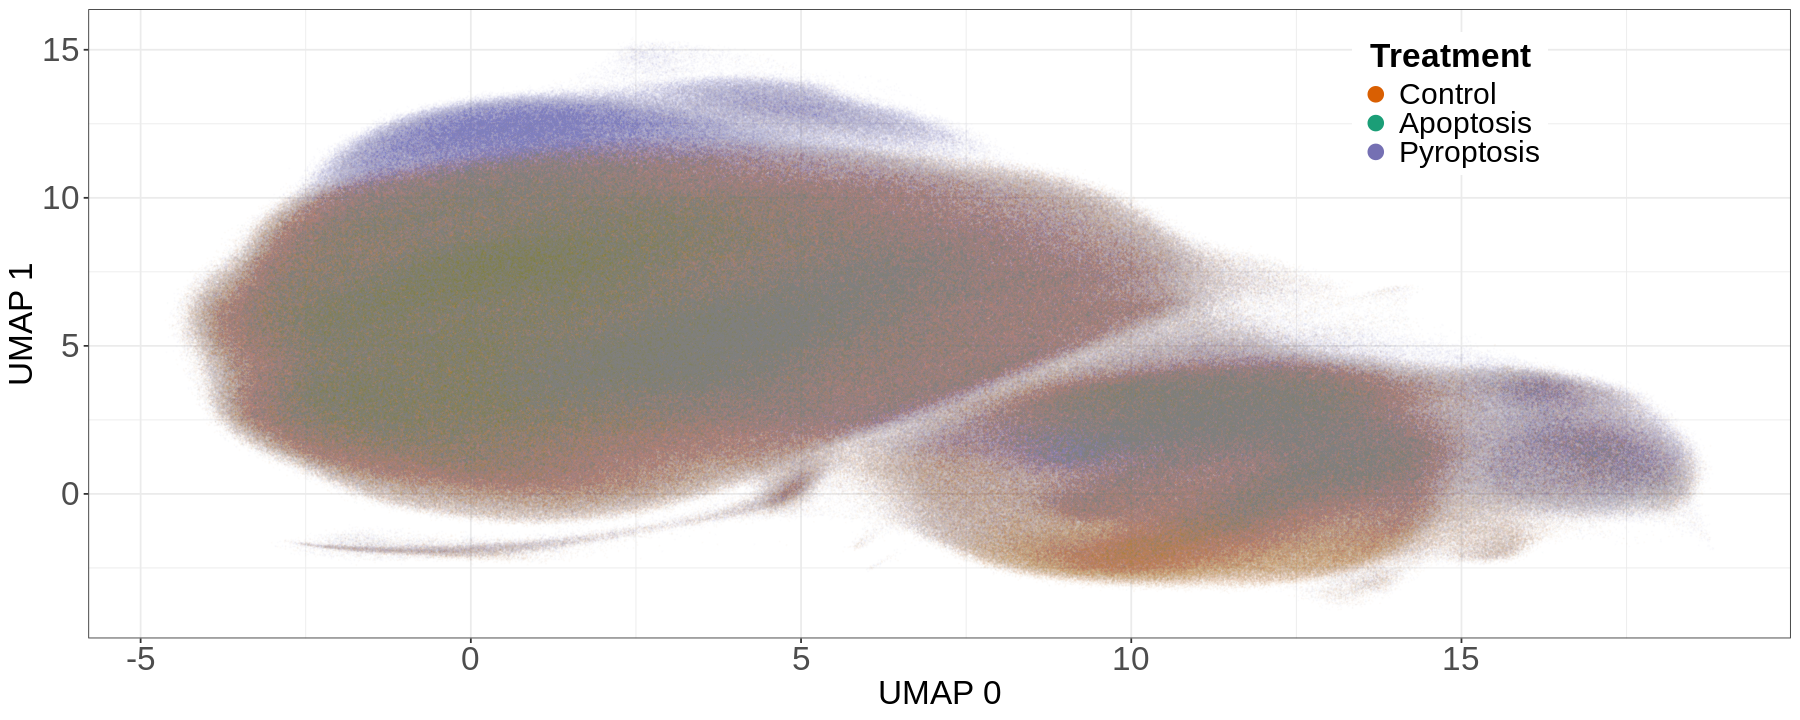

In [24]:
# set plot size 
width <- 15
height <- 6
options(repr.plot.width = width, repr.plot.height = height)
cell_umap <- cell_umap %>% sample_frac(1)
umap_plot_death_type <- (
    ggplot(cell_umap, aes(x = umap_1, y = umap_2)) 

    + geom_point(
        aes(
            color = group,
        ), 
        size = 0.05, 
        alpha = 0.01
    )
    + theme_bw()
    + figure_theme
    + guides(
        color = guide_legend(
            override.aes = list(
                size = 4,
                alpha = 1.5
            )
        )
    )
    + labs(
        x = "UMAP 0",
        y = "UMAP 1",
        color = "Treatment",
    )
    + ggtitle(
        paste0(
            cell_type,
            " UMAP"
        ),
    )
    + theme(
        # change title size
        plot.title = element_text(
            size = 20,
            face = "bold",
            hjust = 0.5
        ),
        legend.title = element_text(
            size = 20,
            face = "bold",
            hjust = 0.5
        ),
    )
    + scale_color_manual(
        name = "Treatment",
        labels = c(
        'Control',
        'Apoptosis',
        'Pyroptosis'
        ),
        values = c(
            brewer.pal(3, "Dark2")[2],
            brewer.pal(3, "Dark2")[1],
            brewer.pal(3, "Dark2")[3]
        ))
    # move the legend to the inside of the plot
    + theme(
        legend.position=c(.80,.85),
        legend.text = element_text(size = 18)
    )
)
# remove the title 
umap_plot_death_type <- umap_plot_death_type + theme(plot.title = element_blank())
umap_plot_death_type


In [25]:
# get the background data for the umap plot
df_background_control <- cell_umap
df_background_control$group <- "Control"
df_background_apoptosis <- cell_umap
df_background_apoptosis$group <- "Apoptosis"
df_background_pyroptosis <- cell_umap
df_background_pyroptosis$group <- "Pyroptosis"

# combine the dataframes
df_background <- rbind(df_background_control, df_background_apoptosis, df_background_pyroptosis)

cell_umap$group <- factor(cell_umap$group, levels = c("Control","Apoptosis","Pyroptosis"))
unique(cell_umap$group)

[1] Control    Pyroptosis Apoptosis 
Levels: Control Apoptosis Pyroptosis

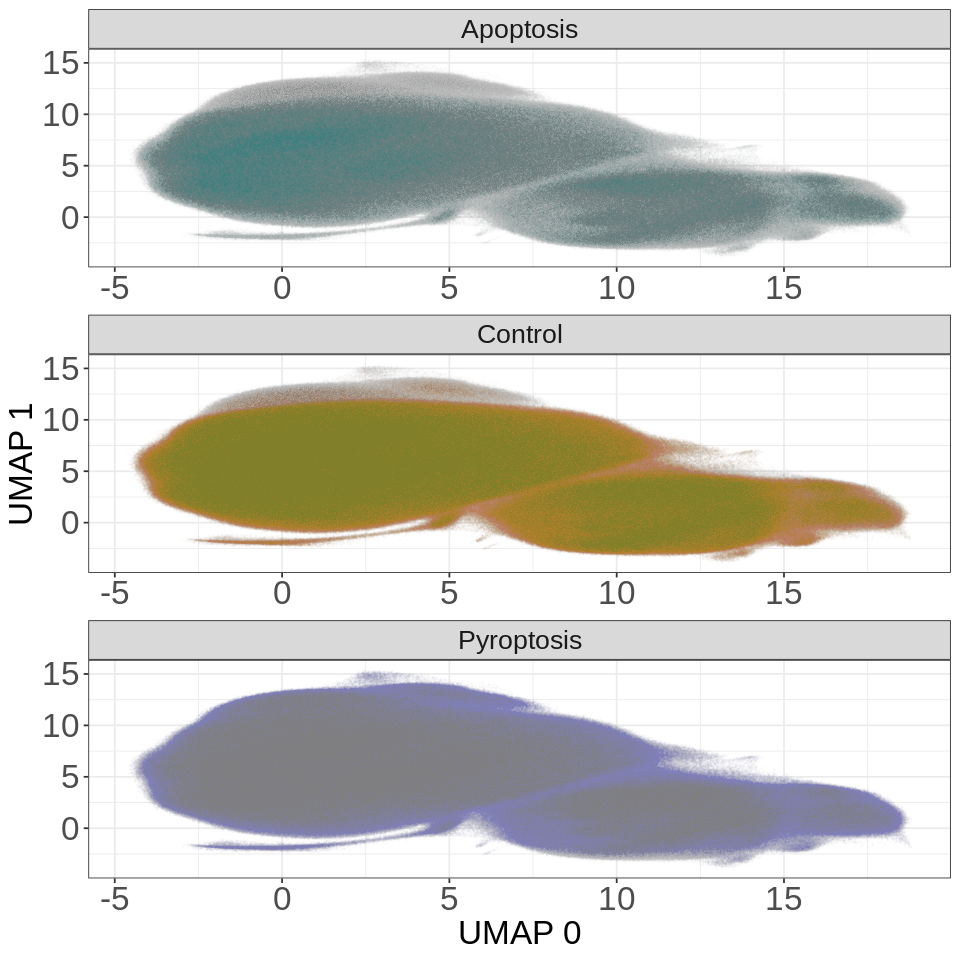

In [26]:
# set plot size 
width <- 8
height <- 8
options(repr.plot.width = width, repr.plot.height = height)
cell_umap <- cell_umap %>% sample_frac(1)
umap_plot_death_type_facet <- (
    cell_umap %>% ggplot( aes(x = umap_1, y = umap_2)) 
    
    + geom_point(
        data = df_background,
        color = "lightgray",
        size = 0.005, 
        alpha = 0.01
    )
    + geom_point(
        aes(
            color = group,
        ), 
        size = 0.005, 
        alpha = 0.01
    )
    + theme_bw()
    + figure_theme

    + scale_color_manual(
        name = "Treatment",
        labels = c(
        'Control',
        'Apoptosis',
        'Pyroptosis'
        ),
        values = c(
            brewer.pal(3, "Dark2")[2],
            brewer.pal(3, "Dark2")[1],
            brewer.pal(3, "Dark2")[3]
        ))
    # move the legend to the inside of the plot
    + theme(
        legend.position="none"
    )

    

    + labs(
        x = "UMAP 0",
        y = "UMAP 1",
        color = "Treatment",
    )
    + ggtitle(
        paste0(
            cell_type,
            " UMAP"
        ),
    )
    # changae the order of the facets
    




    + facet_wrap(group~., scales = "free", ncol = 1)

)
# remove the title 
umap_plot_death_type_facet <- umap_plot_death_type_facet + theme(plot.title = element_blank())
umap_plot_death_type_facet


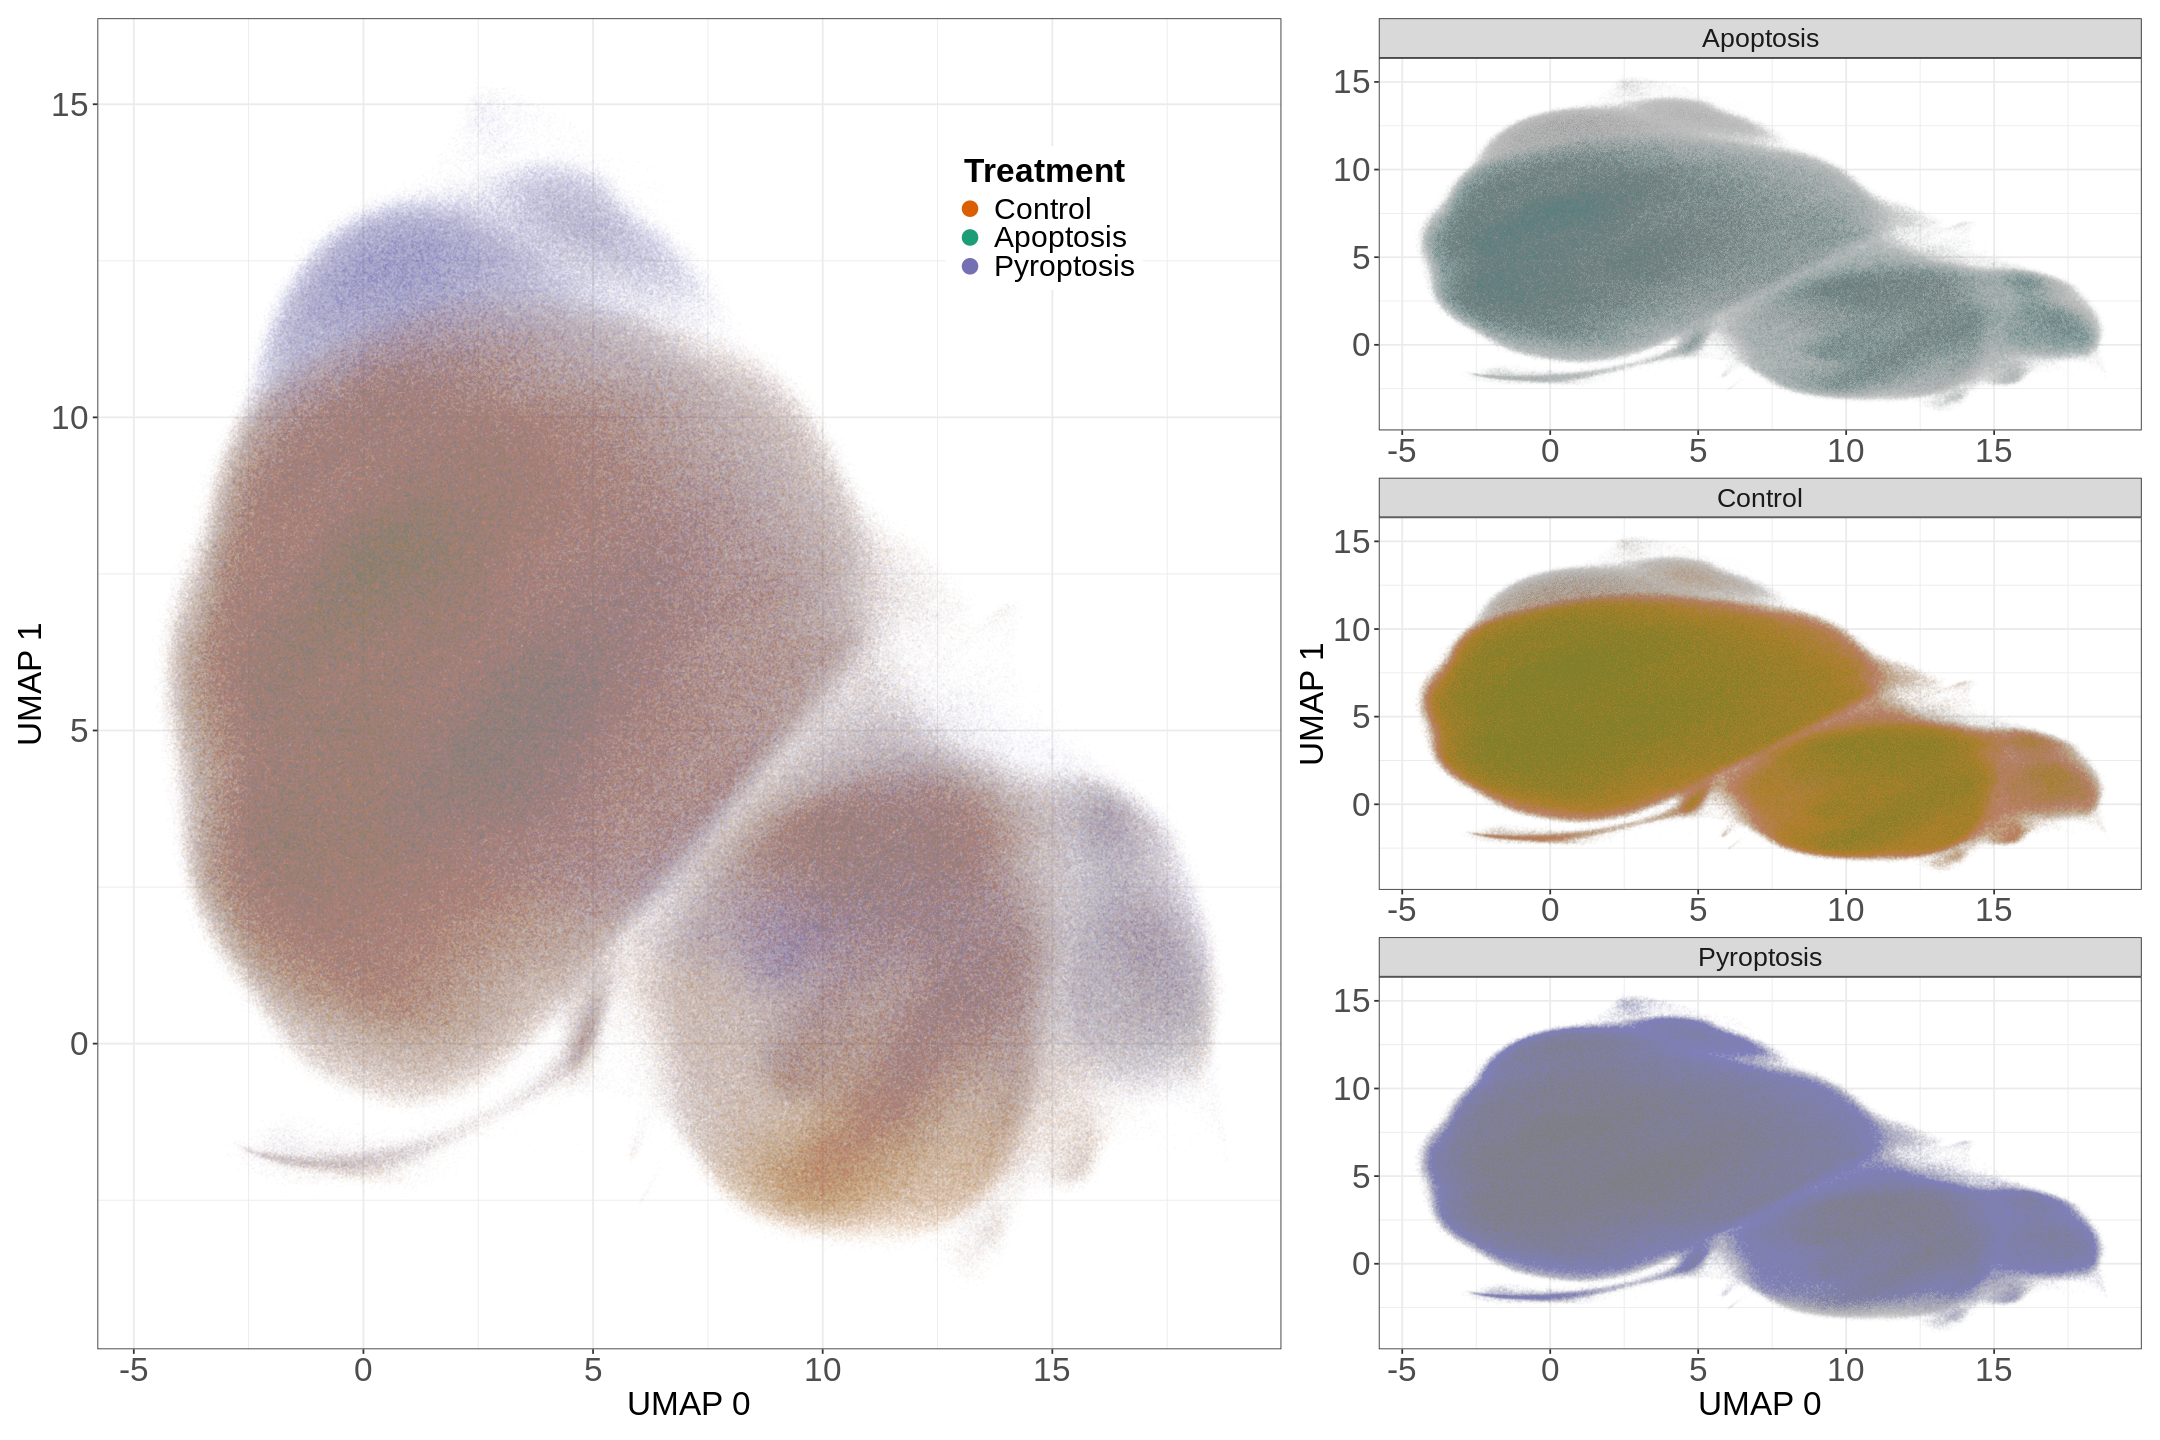

In [27]:
# combine the raw umap and the facet umap using patchwork
layout <- c(
    area(t=1, b=2, l=1, r=3), 
    area(t=1, b=2, l=4, r=5)

)

# patch work the plots together
# set plot size
width <- 18
height <- 12
options(repr.plot.width=width, repr.plot.height=height, units = "in", dpi = 600)


combined_umap_plot <- (
    wrap_elements(full = umap_plot_death_type)
    + wrap_elements(full = umap_plot_death_type_facet)
    + plot_layout(design = layout)
)

combined_umap_plot

## Adjust bar plots

In [28]:
# change bar plot title colours to match the venn diagram

a_h_unique_plot <- a_h_unique_plot + theme(
    plot.title = element_text(
        color=brewer.pal(3, "Dark2")[1], 
        size=14, 
        face="bold", 
        hjust = 0.5
        # remove x axis label

    ),
    axis.title.x = element_blank()
)
a_p_unique_plot <- a_p_unique_plot + theme(
    plot.title = element_text(
        color=brewer.pal(3, "Dark2")[2], 
        size=14, 
        face="bold", 
        hjust = 0.5
        # remove x axis label

    ),
    axis.title.x = element_blank()
)
h_p_unique_plot <- h_p_unique_plot + theme(
    plot.title = element_text(
        color=brewer.pal(3, "Dark2")[3], 
        size=14, 
        face="bold", 
        hjust = 0.5
        # remove x axis label

    ),
    axis.title.x = element_blank()
)
a_h__a_p__h_p_common_plot <- a_h__a_p__h_p_common_plot + ggtitle(
    "All Different Features"
) + theme(
    plot.title = element_text(
        color="black", 
        size=14, 
        face="bold", 
        hjust = 0.5
        # remove x axis label

    ),
    axis.title.x = element_blank()

)

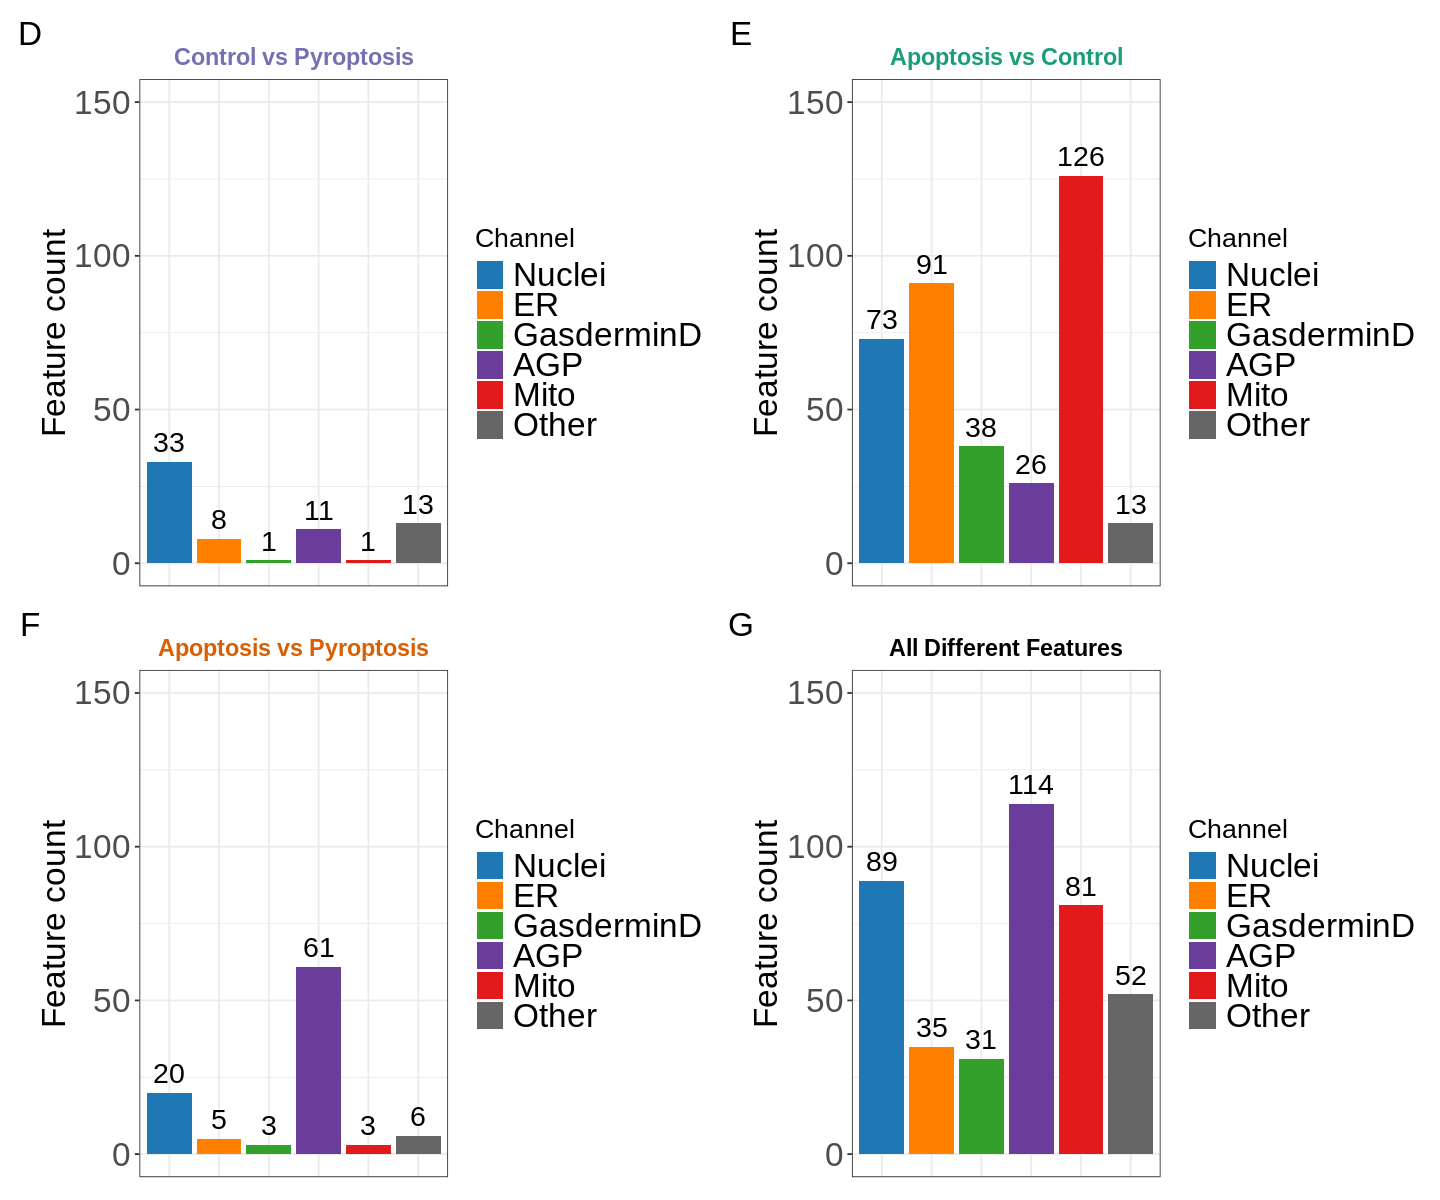

In [29]:
# patch work plot of the venn diagram and bar plots


layout <- c(
    area(t=1, b=2, l=1, r=2), 
    area(t=1, b=2, l=3, r=4), 
    area(t=3, b=4, l=1, r=2), 
    area(t=3, b=4, l=3, r=4)
)

# set plot size
width <- 12
height <- 10
options(repr.plot.width=width, repr.plot.height=height)
sub_figure3 <- (
    h_p_unique_plot
    + a_h_unique_plot
    + a_p_unique_plot
    + a_h__a_p__h_p_common_plot
    
    + plot_layout(design = layout)
    + plot_annotation(tag_levels = list(c( "D", "E", "F", "G"))) & theme(plot.tag = element_text(size = 20))

)
sub_figure3


## Plot the distibution of the selected features for each class

In [30]:
# import morphology data 
columns_to_import <- c("oneb_Metadata_Treatment_Dose_Inhibitor_Dose", "Cytoplasm_RadialDistribution_ZernikePhase_CorrGasdermin_9_1")
# path to the parquet file
morphology_path <- file.path(
    "..","..","..","data","PBMC_preprocessed_sc_norm.parquet"
)

# read in the parquet file with certain columns
morphology_df <- arrow::read_parquet(morphology_path, col_select = all_of(columns_to_import))

# read in the specific image values
image_values_path <- file.path(
    "..","results","features_values.csv"
)
features_values <- read_csv(image_values_path)
control_value <- features_values$Cytoplasm_RadialDistribution_ZernikePhase_CorrGasdermin_9_1[1]
apoptosis_value <- features_values$Cytoplasm_RadialDistribution_ZernikePhase_CorrGasdermin_9_1[2]
pyroptosis_value <- features_values$Cytoplasm_RadialDistribution_ZernikePhase_CorrGasdermin_9_1[3]


Rows: 3 Columns: 36
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (25): oneb_Metadata_Treatment_Dose_Inhibitor_Dose, group, Metadata_Well,...
dbl (11): Metadata_Nuclei_Location_Center_Y, Metadata_Nuclei_Location_Center...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Warning message:
“Unknown or uninitialised column: `Cytoplasm_RadialDistribution_ZernikePhase_CorrGasdermin_9_1`.”
Warning message:
“Unknown or uninitialised column: `Cytoplasm_RadialDistribution_ZernikePhase_CorrGasdermin_9_1`.”
Warning message:
“Unknown or uninitialised column: `Cytoplasm_RadialDistribution_ZernikePhase_CorrGasdermin_9_1`.”


In [31]:
morphology_df$oneb_Metadata_Treatment_Dose_Inhibitor_Dose <- ifelse(morphology_df$oneb_Metadata_Treatment_Dose_Inhibitor_Dose == "Flagellin_0.100_ug_per_ml_DMSO_0.000_%", "Flagellin_0.100_ug_per_ml_DMSO_0.025_%", morphology_df$oneb_Metadata_Treatment_Dose_Inhibitor_Dose)
morphology_df$oneb_Metadata_Treatment_Dose_Inhibitor_Dose <- ifelse(morphology_df$oneb_Metadata_Treatment_Dose_Inhibitor_Dose == "media_ctr_0.0_0_Media_0_0", "media_ctr_0.0_0_Media_ctr_0.0_0", morphology_df$oneb_Metadata_Treatment_Dose_Inhibitor_Dose)
morphology_df$oneb_Metadata_Treatment_Dose_Inhibitor_Dose <- ifelse(morphology_df$oneb_Metadata_Treatment_Dose_Inhibitor_Dose == "Flagellin_1.000_ug_per_ml_DMSO_0.000_%", "Flagellin_1.000_ug_per_ml_DMSO_0.0_%", morphology_df$oneb_Metadata_Treatment_Dose_Inhibitor_Dose)
morphology_df$oneb_Metadata_Treatment_Dose_Inhibitor_Dose <- ifelse(morphology_df$oneb_Metadata_Treatment_Dose_Inhibitor_Dose == "Flagellin_1.000_0_Disulfiram_1.000_uM", "Flagellin_1.000_ug_per_ml_Disulfiram_1.000_uM", morphology_df$oneb_Metadata_Treatment_Dose_Inhibitor_Dose)
morphology_df$oneb_Metadata_Treatment_Dose_Inhibitor_Dose <- ifelse(morphology_df$oneb_Metadata_Treatment_Dose_Inhibitor_Dose == "Flagellin_1.000_ug_per_ml_DMSO_0.000_%", "Flagellin_1.000_ug_per_ml_DMSO_0.0_%", morphology_df$oneb_Metadata_Treatment_Dose_Inhibitor_Dose)
morphology_df$oneb_Metadata_Treatment_Dose_Inhibitor_Dose <- ifelse(morphology_df$oneb_Metadata_Treatment_Dose_Inhibitor_Dose == "Flagellin_1.000_0_DMSO_0.025_%", "Flagellin_1.000_ug_per_ml_DMSO_0.0_%", morphology_df$oneb_Metadata_Treatment_Dose_Inhibitor_Dose)


length(unique(morphology_df$oneb_Metadata_Treatment_Dose_Inhibitor_Dose))
unique(morphology_df$oneb_Metadata_Treatment_Dose_Inhibitor_Dose)

[1] 37

[1] "LPS_0.010_ug_per_ml_DMSO_0.025_%"                            
 [2] "LPS_0.100_ug_per_ml_DMSO_0.025_%"                            
 [3] "LPS_Nigericin_100.000_ug_per_ml_1.000_uM_DMSO_0.025_%"       
 [4] "LPS_Nigericin_100.000_ug_per_ml_3.000_uM_DMSO_0.025_%"       
 [5] "DMSO_0.100_%_DMSO_0.025_%"                                   
 [6] "Media"                                                       
 [7] "DMSO_0.100_%_DMSO_1.000_%"                                   
 [8] "LPS_1.000_ug_per_ml_DMSO_0.025_%"                            
 [9] "LPS_10.000_ug_per_ml_DMSO_0.025_%"                           
[10] "LPS_Nigericin_100.000_ug_per_ml_10.000_uM_DMSO_0.025_%"      
[11] "Disulfiram_0.100_uM_DMSO_0.025_%"                            
[12] "Thapsigargin_1.000_uM_DMSO_0.025_%"                          
[13] "Thapsigargin_10.000_uM_DMSO_0.025_%"                         
[14] "DMSO_0.100_%_Z-VAD-FMK_100.000_uM"                           
[15] "DMSO_0.100_%_Z-VAD-FMK_30.000_uM"                            
[16] "LPS_10.000_ug_per_ml_Disulfiram_0.100_uM"                    
[17] "LPS_10.000_ug_per_ml_Disulfiram_1.000_uM"                    
[18] "Disulfiram_1.000_uM_DMSO_0.025_%"                            
[19] "Disulfiram_2.500_uM_DMSO_0.025_%"                            
[20] "Topotecan_5.000_nM_DMSO_0.025_%"                             
[21] "Topotecan_10.000_nM_DMSO_0.025_%"                            
[22] "LPS_10.000_ug_per_ml_Disulfiram_2.500_uM"                    
[23] "LPS_10.000_ug_per_ml_Z-VAD-FMK_100.000_uM"                   
[24] "H2O2_100.000_nM_DMSO_0.025_%"                                
[25] "H2O2_100.000_uM_DMSO_0.025_%"                                
[26] "Topotecan_20.000_nM_DMSO_0.025_%"                            
[27] "LPS_100.000_ug_per_ml_DMSO_0.025_%"                          
[28] "LPS_Nigericin_1.000_ug_per_ml_1.000_uM_DMSO_0.025_%"         
[29] "H2O2_100.000_uM_Disulfiram_1.000_uM"                         
[30] "H2O2_100.000_uM_Z-VAD-FMK_100.000_uM"                        
[31] "LPS_Nigericin_1.000_ug_per_ml_3.000_uM_DMSO_0.025_%"         
[32] "LPS_Nigericin_1.000_ug_per_ml_10.000_uM_DMSO_0.025_%"        
[33] "Flagellin_0.100_ug_per_ml_DMSO_0.025_%"                      
[34] "Flagellin_1.000_ug_per_ml_DMSO_0.025_%"                      
[35] "LPS_Nigericin_1.000_ug_per_ml_10.000_uM_Disulfiram_1.000_uM" 
[36] "LPS_Nigericin_1.000_ug_per_ml_10.000_uM_Z-VAD-FMK_100.000_uM"
[37] "Flagellin_1.000_ug_per_ml_Disulfiram_1.000_uM"

In [32]:
# replace Flagellin_0.100_ug_per_ml_DMSO_0.0_% with Flagellin_0.100_ug_per_ml_DMSO_0.025_%

# make a new column that is the treatment group based on the ground truth data
morphology_df$group <- ifelse(morphology_df$oneb_Metadata_Treatment_Dose_Inhibitor_Dose %in% apoptosis_ground_truth_list, "Apoptosis",
                                ifelse(morphology_df$oneb_Metadata_Treatment_Dose_Inhibitor_Dose %in% pyroptosis_ground_truth_list, "Pyroptosis",
                                       ifelse(morphology_df$oneb_Metadata_Treatment_Dose_Inhibitor_Dose %in% control_ground_truth_list, "Control", "NA")))
# make the group column a factor
morphology_df$group <- factor(morphology_df$group, levels = c("Control","Apoptosis", "Pyroptosis"))

unique(morphology_df$group)


[1] Pyroptosis Control    Apoptosis 
Levels: Control Apoptosis Pyroptosis

In [33]:
head(morphology_df)
# get only rows that contain the control or apoptosis or pyroptosis
control_df <- morphology_df %>% filter(group == "Control")
apoptosis_df <- morphology_df %>% filter(group == "Apoptosis")
pyroptosis_df <- morphology_df %>% filter(group == "Pyroptosis")

oneb_Metadata_Treatment_Dose_Inhibitor_Dose
1 LPS_0.010_ug_per_ml_DMSO_0.025_%           
2 LPS_0.010_ug_per_ml_DMSO_0.025_%           
3 LPS_0.010_ug_per_ml_DMSO_0.025_%           
4 LPS_0.010_ug_per_ml_DMSO_0.025_%           
5 LPS_0.010_ug_per_ml_DMSO_0.025_%           
6 LPS_0.010_ug_per_ml_DMSO_0.025_%           
  Cytoplasm_RadialDistribution_ZernikePhase_CorrGasdermin_9_1 group     
1  0.8709861                                                  Pyroptosis
2 -0.7533978                                                  Pyroptosis
3  1.1844285                                                  Pyroptosis
4  1.6312785                                                  Pyroptosis
5  0.5607880                                                  Pyroptosis
6 -0.9509009                                                  Pyroptosis

## Assemble final plot

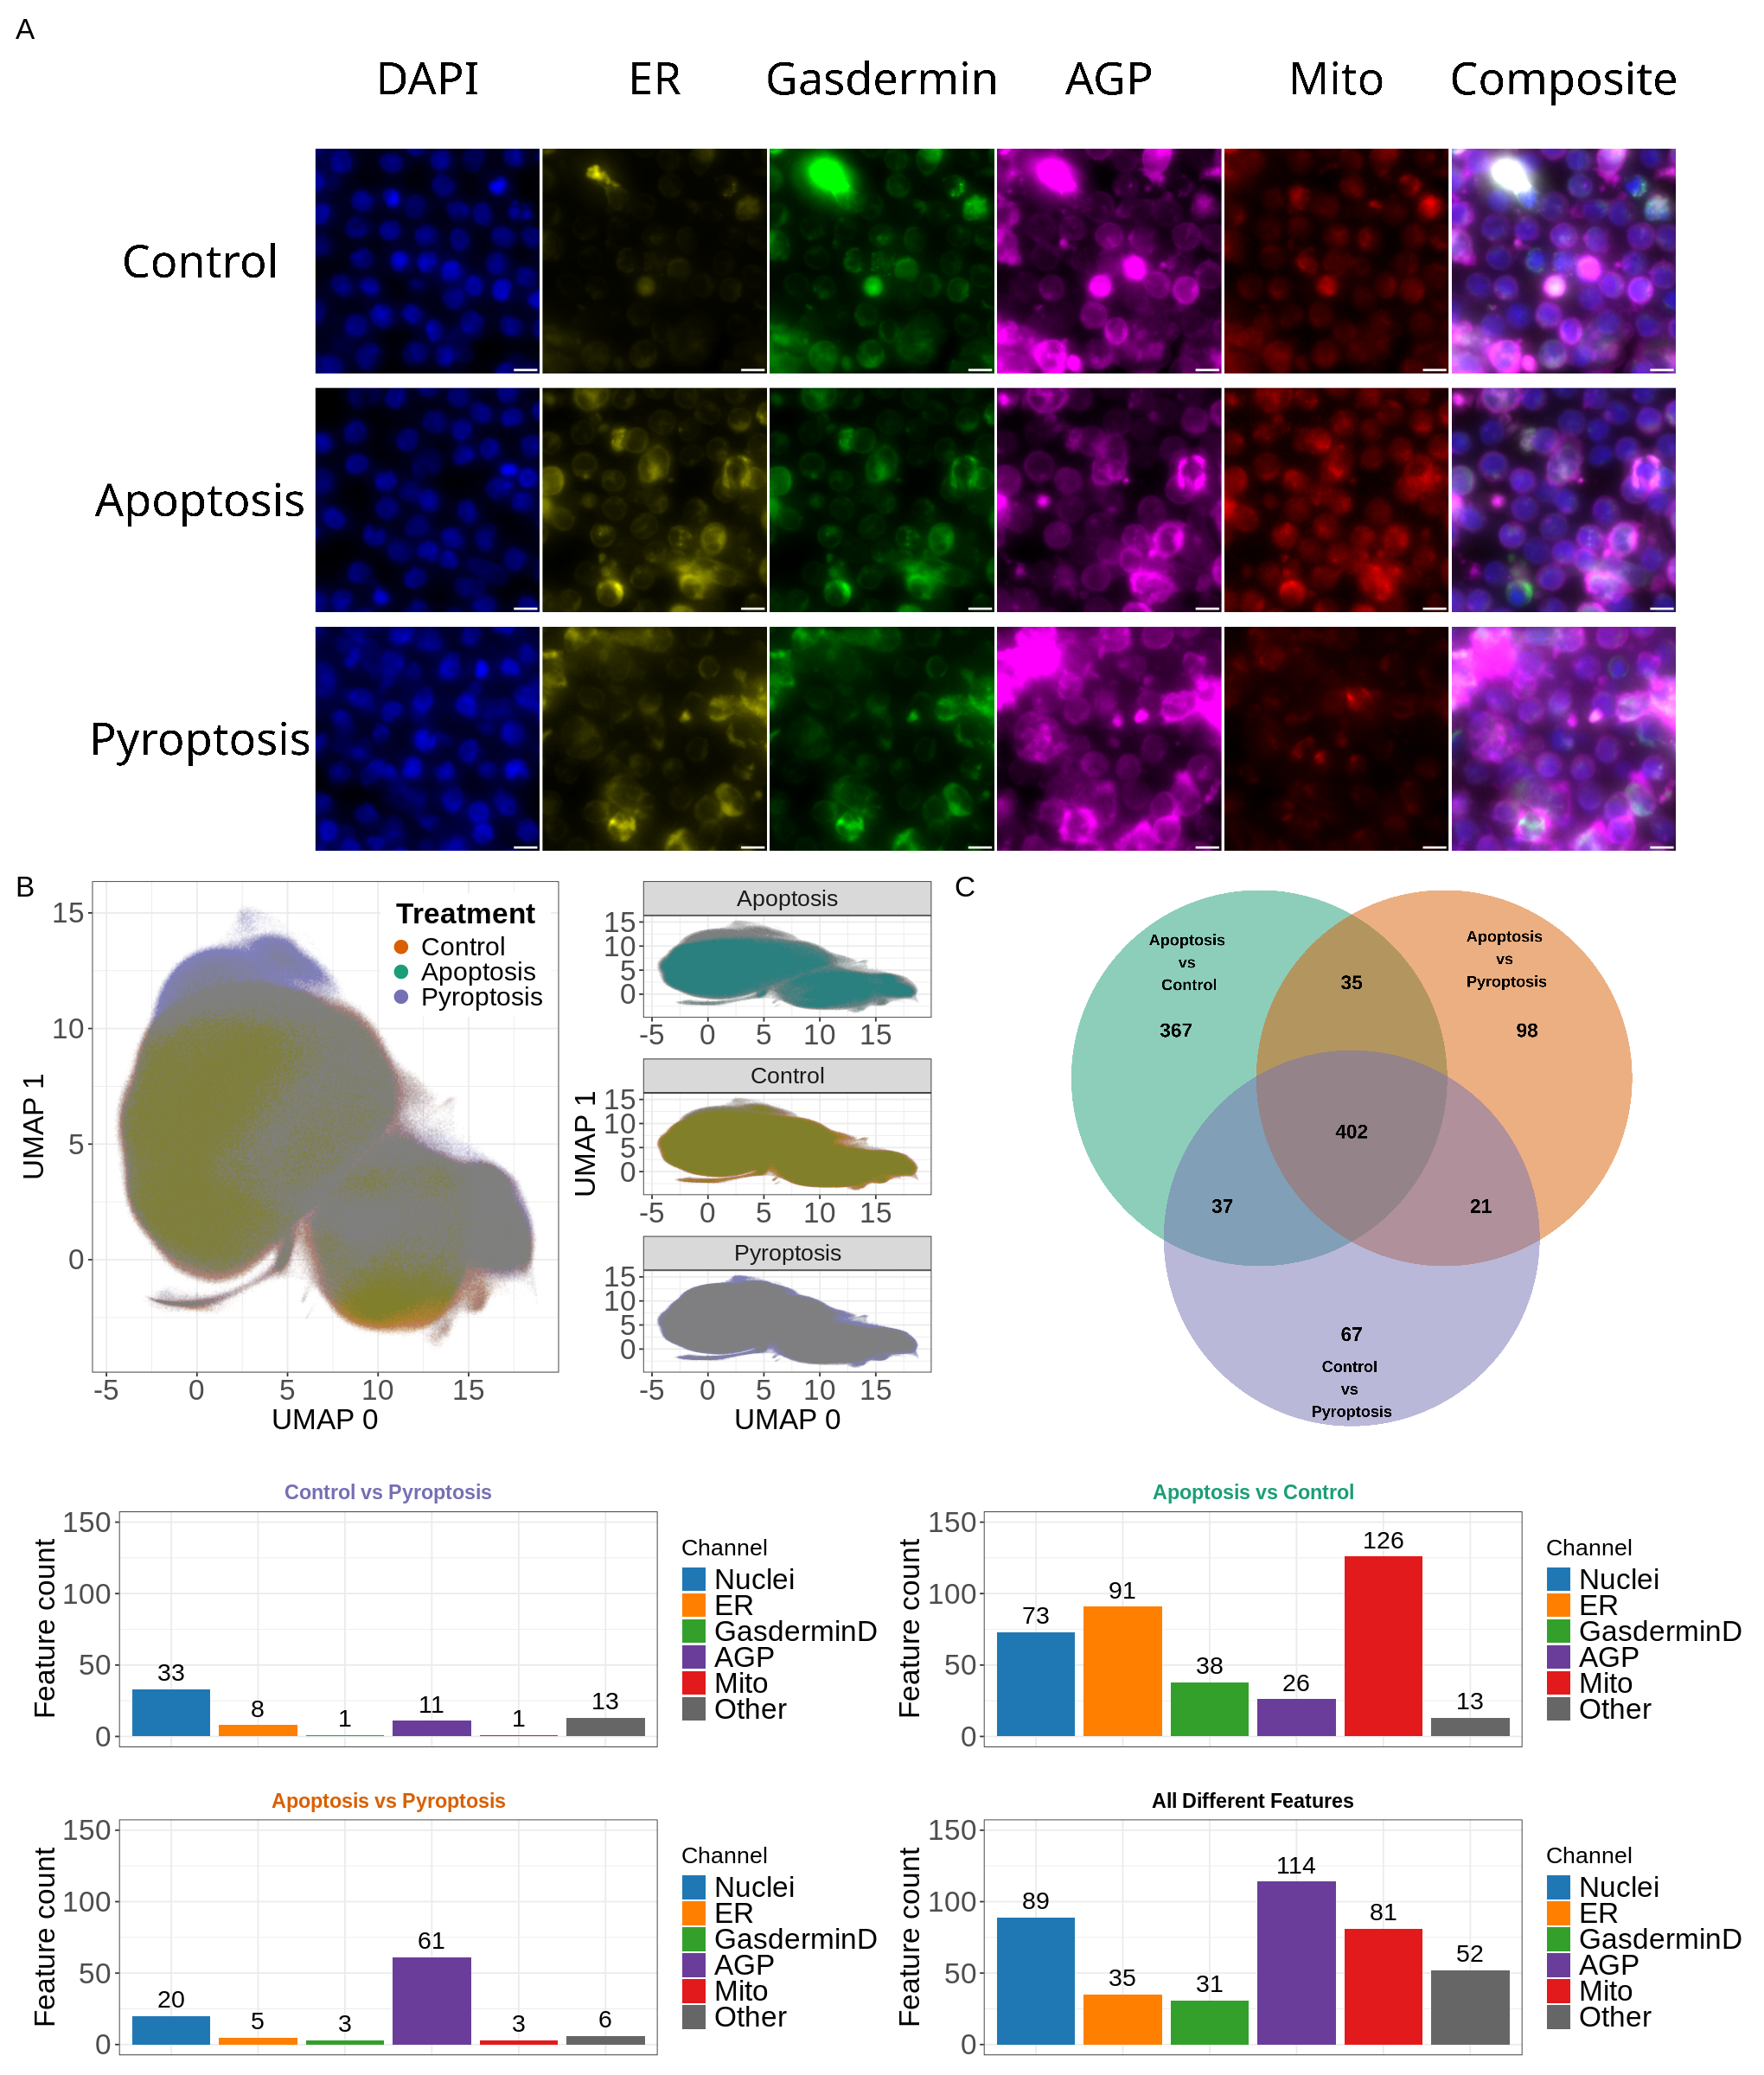

In [34]:
layout <- c(
    area(t=1, b=3, l=1, r=5), 
    area(t=4, b=5, l=1, r=3.5),
    area(t=4, b=5, l=4, r=5),
    area(t=6, b=7, l=1, r=5)
)

# patch work the plots together
# set plot size
width <- 17
height <- 20
options(repr.plot.width=width, repr.plot.height=height, units = "in", dpi = 600)

fig3 <- (
    wrap_elements(full = montage)
    # montage
    + wrap_elements(full = combined_umap_plot)
    + wrap_elements(full = venn_diagram_image)
    # + wrap_elements(full = sub_figure3)
    + sub_figure3
    + plot_layout(design = layout)
    # make bottom plot not align
    + plot_annotation(tag_levels = list(c("A", "B", "C"))) & theme(plot.tag = element_text(size = 20))

)
ggsave(
    filename = file.path("..","figures",paste0(cell_type,"_figure3.png")),
    plot = fig3,
    width = width,
    height = height,
    units = "in",
    dpi = 600
)

fig3

In [35]:
sessionInfo()

R version 4.2.2 (2022-10-31)
Platform: x86_64-conda-linux-gnu (64-bit)
Running under: Pop!_OS 22.04 LTS

Matrix products: default
BLAS/LAPACK: /home/lippincm/miniforge3/envs/Interstellar_R/lib/libopenblasp-r0.3.27.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] grid      stats     graphics  grDevices utils     datasets  methods  
[8] base     

other attached packages:
 [1] Polychrome_1.5.1      ggvenn_0.1.10         forcats_1.0.0        
 [4] readr_2.1.5           tidyr_1.3.1           tibble_3.2.1         
 [7] tidyverse_1.3.2       VennDiagram_1.7.3     futile.logger_1.4.3  
[10] purrr_1.0.2           stringr_1.5.1         reshape2_1.4.4     